In [48]:
import os
import sys
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import gseapy as gp

pl.seed_everything(32)

sys.path.append("/data/danai/scripts/LIVI/")
from src.analysis._utils import select_important_genes_for_factor_IQR
from src.analysis.plotting import make_gp_dotplot

Seed set to 32


In [2]:
adata = sc.read_h5ad("/data/danai/Data/OneK1K/LogNorm_counts_across_celltypes_DCRM_protein-coding_Azimuth_only-immune-cells_HVG-HEX-10K.h5ad")
adata

AnnData object with n_obs × n_vars = 1172790 × 14212
    obs: 'orig_ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent_mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MITO', 'log1p_total_counts_MITO', 'pct_counts_MITO', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'Norm_factors', 'major_celltype', 'predicted_celltype_l0', 'predicted_celltype_l1', 'predicted_celltype_l2', 'original_celltype', 'new_predicted_celltype_l2', 'new_predicted_celltype_l0', 'new_predicted_celltype_l1'
    var: 'GeneSymbol', 'features', 'MITO', 'RIBO', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'downregulated_NK', '

In [3]:
gene_anno = pd.read_csv("/data/danai/Data/OneK1K/OneK1K_HVG-HEX-10K_geneIDs_Biomart.txt", sep="\t", index_col=0)
gene_anno.rename(columns={"Gene stable ID":"feature_id", 
                         "Gene name":"gene_name",
                         "Chromosome/scaffold name":"gene_chromosome", 
                         "Gene start (bp)":"gene_start", 
                         "Gene end (bp)":"gene_end"},
                inplace=True)
gene_anno

,gene_start,gene_chromosome,gene_end,gene_name
Gene stable ID,,,,
ENSG00000000419,49551404,20,49575092,DPM1
ENSG00000000457,169818772,1,169863408,SCYL3
ENSG00000000460,169631245,1,169823221,C1orf112
ENSG00000000938,27938575,1,27961788,FGR
ENSG00000000971,196621008,1,196716634,CFH
...,...,...,...,...
ENSG00000273269,47293080,2,47403650,RP11-761B3.1
ENSG00000273274,32930670,1,32962287,ZBTB8B
ENSG00000273294,33987279,5,34124633,RP11-1084J3.4


In [4]:
adata.var.GeneSymbol = adata.var.GeneSymbol.str.strip()
adata.var = adata.var.merge(gene_anno.filter(["gene_chromosome", "gene_start", "gene_end"]), right_index=True, left_index=True)
adata.var

,GeneSymbol,features,MITO,RIBO,ERCC,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,...,downregulated_CD8T,upregulated_B,downregulated_B,upregulated_Mono,downregulated_Mono,upregulated_DC,downregulated_DC,gene_chromosome,gene_start,gene_end
ENSG00000257019,OR13C2,OR13C2,False,False,False,3,0.000002,0.000002,99.999764,3.0,...,False,False,False,False,False,False,False,9,107366924,107367951
ENSG00000166987,MBD6,MBD6,False,False,False,34604,0.027840,0.027459,97.280605,35426.0,...,True,True,True,True,False,False,True,12,57914493,57923931
ENSG00000170624,SGCD,SGCD,False,False,False,1844,0.001487,0.001486,99.855087,1892.0,...,False,True,True,True,True,False,True,5,155297354,156194799
ENSG00000140519,RHCG,RHCG,False,False,False,2,0.000002,0.000002,99.999843,2.0,...,False,False,False,False,False,False,False,15,89998680,90039844
ENSG00000117115,PADI2,PADI2,False,False,False,2728,0.002279,0.002276,99.785617,2900.0,...,True,True,True,True,False,True,True,1,17393256,17445948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000185811,IKZF1,IKZF1,False,False,False,338926,0.332737,0.287235,73.365114,423404.0,...,True,True,True,True,True,False,True,7,50343720,50472799
ENSG00000234465,PINLYP,PINLYP,False,False,False,3098,0.002490,0.002487,99.756540,3168.0,...,False,False,False,False,False,False,False,19,44080952,44088116
ENSG00000170615,SLC26A5,SLC26A5,False,False,False,685,0.000540,0.000540,99.946168,687.0,...,False,False,False,False,False,False,False,7,102993177,103086624
ENSG00000151778,SERP2,SERP2,False,False,False,2513,0.002013,0.002011,99.802513,2561.0,...,True,True,True,True,True,False,True,13,44947801,44971850


In [5]:
background_genes = adata.var.GeneSymbol

names = gp.get_library_name("Human")
names

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [6]:
ct_annotations_db = ["Azimuth_Cell_Types_2021", "Tabula_Sapiens"]

In [7]:
results_dir = "/data/danai/Data/OneK1K/LIVI2_testing_results/"
model = "2024-12-05_10-20_LIVIcis-cell-state_zdim15_700-gxc_5-persistent_60-0-warm-up_no-adversary_Gseed200_hvg-hex-10K_larger-encoder_best"
model_results_dir = os.path.join(results_dir, model)
os.path.isdir(model_results_dir)

True

In [8]:
# COLORS FROM THE ORIGINAL PUBLICATION
cell_label_colors = {
    "CD4 SOX4": "#D6C1DE", # SOX4+ CD4 T cells
    "CD4 NC": "#882E72", # CD4 naive T cells
    "CD4 ET": "#B178A6", # CD4 effectorT  cells
    "CD8 NC": "#5289C7", # CD8 naive T cells
    "CD8 S100B": "#7BAFDE", # S100B+ CD8 cells
    "CD8 ET": "#1965B0", # CD8 effector cells 
    "NK": "#4EB265",
    "NK R": "#90C987", # NK recruiting cells
    "B IN": "#F6C141",
    "B Mem": "#F7EE55",
    "Mono C": "#F1932D", # classical monocytes
    "Mono NC": "#E8601C", # non-classical monocytes
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

# matching colros for major (L1) celltype
major_celltype_colors = {
    "CD4T": "darkmagenta",
    "CD8T": "steelblue", 
    "NK": "mediumseagreen",
    "B": "gold",
    "Mono": "orange",
    "DC": "#DC050C",
    "Plasma": "#CAE0AB",
}

In [9]:
cell_state = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_cell-state_latent.tsv"),
sep="\t", index_col=0)

In [10]:
cc_decoder = pd.read_csv(
    os.path.join(model_results_dir, f"{model}_cell-state_decoder.tsv"),
sep="\t", index_col=0)

### Violin plots cell-state factors

In [11]:
plot_df = cell_state.merge(adata.obs.cell_label, right_index=True, left_index=True).rename(columns={"cell_label":"Cell type"})
plot_df

,Cell-state_Factor1,Cell-state_Factor2,Cell-state_Factor3,Cell-state_Factor4,Cell-state_Factor5,Cell-state_Factor6,Cell-state_Factor7,Cell-state_Factor8,Cell-state_Factor9,Cell-state_Factor10,Cell-state_Factor11,Cell-state_Factor12,Cell-state_Factor13,Cell-state_Factor14,Cell-state_Factor15,Cell type
barcode,,,,,,,,,,,,,,,,
AAACCTGAGAATGTTG-1,-0.055564,0.204060,1.013135,-1.395821,1.444505,-1.279546,-0.893336,-0.689094,-1.438431,0.274018,0.751038,-0.644062,0.139367,-0.067002,0.392196,CD4 ET
AAACCTGAGAGAACAG-1,0.435927,-0.421920,-0.401758,0.191706,-0.353541,-0.173912,-1.028241,0.464185,0.566248,-0.137772,0.478904,1.862952,0.288139,-0.963725,-0.728154,NK
AAACCTGAGCATGGCA-1,0.079476,0.142409,0.128506,0.280768,0.285578,-0.714832,0.245650,-0.028575,0.672667,1.417376,-0.135554,-0.763835,1.474994,0.610733,-0.318393,CD4 NC
AAACCTGAGTATTGGA-1,0.364101,0.200015,0.176564,0.570446,0.596151,-0.969825,-0.644402,-0.387912,-0.825339,0.953428,0.731503,0.619751,0.525924,-1.169301,-0.375607,CD8 S100B
AAACCTGAGTGTCCCG-1,1.307115,-1.082183,-0.430110,0.016896,0.521049,-0.017032,-0.713022,0.728915,0.261433,1.196877,0.152072,0.723485,-1.403069,-0.852683,0.832266,CD8 ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCGCTGTT-9,-0.695335,0.561318,1.462784,-0.457174,0.350676,-0.692081,2.223392,0.355208,0.463841,-0.748622,1.070863,-0.104265,0.020000,-1.215783,-0.217983,B IN
TTTGTCATCCGTTGTC-9,0.239417,-0.088748,0.509074,-0.351015,1.273174,-0.889245,0.672222,-0.728480,0.039765,0.812572,-0.099767,-0.361258,1.040613,-0.692962,0.700493,CD4 NC
TTTGTCATCGCCGTGA-9,-0.180129,-0.865665,0.351757,-0.478586,1.123208,0.034449,0.272101,-2.013950,-0.754734,1.336217,-0.185580,-0.024612,1.983244,-1.178277,-0.018026,CD4 NC


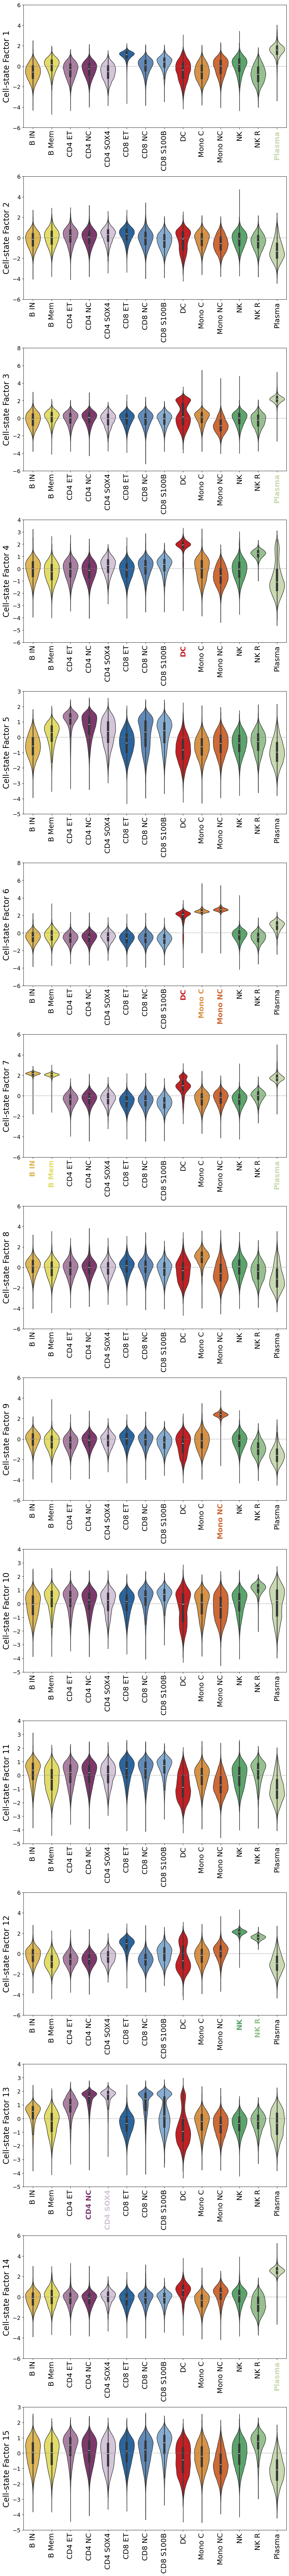

In [14]:
fig, axs = plt.subplots(nrows=cell_state.shape[1],figsize=(10,6*cell_state.shape[1]), constrained_layout=True)
axs = axs.flatten()
for i in range(len(cell_state.columns)):
    fc = cell_state.columns[i]
    plot_df_fc = plot_df.filter([fc, "Cell type"])
    violins = sns.violinplot(x="Cell type", y=fc, data=plot_df_fc, hue="Cell type", ax=axs[i], palette = cell_label_colors)
    axs[i].axhline(y=0, color="grey", linestyle=":")
    axs[i].set_ylabel(fc.replace("_", " ").replace("r", "r "), fontsize=20)
    axs[i].set_yticks(axs[i].get_yticks(), axs[i].get_yticklabels(), fontsize=14)
    axs[i].set_xlabel("")
    axs[i].set_xticks(axs[i].get_xticks(), axs[i].get_xticklabels(), rotation=90, fontsize=18)
    # Extract the colors used by the violins
    violin_colors = [child.get_facecolor() for child in violins.collections[::1]]
    # Color the label of the celltype(s) that characterize the given factor
    for j, label in enumerate(axs[i].get_xticklabels()):
        category = label.get_text()
        if plot_df_fc.loc[plot_df_fc["Cell type"] == category][fc].median() > 1.5: # (plot_df_fc[fc].mean()+1*iqr(plot_df_fc[fc])):
            label.set_color(violin_colors[j])
            label.set_fontweight("bold")

plt.savefig(os.path.join(model_results_dir, "Figures", f"{model}_Violin-plots_cell-state-factors_celltypes.png"), 
            transparent=True, dpi=500, bbox_inches="tight")

### GSEA for cell-state factors

In [15]:
ct_enrichment_results = []

In [16]:
f1_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=0, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f1_up))

enr_f1_high = gp.enrichr(gene_list = f1_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f1_high.results.loc[enr_f1_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1362


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD56-dim Natural Killer 1 CL0000939,6.421016e-11,9.374684e-09,0,0,inf,inf,FGFBP2;LGALS1;KLRC2;GNLY;PRF1;GZMB;NKG7;S100A4...
1,Azimuth_Cell_Types_2021,CD8+ Effector Memory T 1 CL0001050,7.053712e-09,5.149210e-07,0,0,inf,inf,GZMK;IL32;DUSP2;CD8B;CD8A;CCL5;NKG7;CST7
2,Azimuth_Cell_Types_2021,CD4+ Cytotoxic T CL0000934,1.399627e-08,6.811517e-07,0,0,31.629684,572.006241,IL32;FGFBP2;GNLY;GZMA;CCL5;NKG7;S100A4;CST7;B2...
3,Azimuth_Cell_Types_2021,CD8 T CL0000625,2.658839e-07,6.469842e-06,0,0,37.902511,573.851824,CD8B;CD8A;CCL5;GZMA;NKG7;CD3G;CD3D;GZMH
4,Azimuth_Cell_Types_2021,CD8+ Effector Memory T 4 CL0001050,2.658839e-07,6.469842e-06,0,0,37.902511,573.851824,CD2;FGFBP2;CD8B;CD8A;GNLY;THEMIS;GZMB;GZMH
5,Azimuth_Cell_Types_2021,CD8+ Memory/Effector T CL0000625,2.658839e-07,6.469842e-06,0,0,37.902511,573.851824,IL32;DUSP2;CD8A;CCL5;NKG7;CD3E;CST7;TC2N
6,Azimuth_Cell_Types_2021,CD8+ Effector Memory T CL0001050,5.414858e-07,7.905692e-06,0,0,66.285609,956.431671,GZMK;CD8B;CD8A;CCL5;NKG7;CST7;GZMH
7,Azimuth_Cell_Types_2021,CD8+ Effector Memory T 5 CL0001050,5.414858e-07,7.905692e-06,0,0,66.285609,956.431671,ZNF683;CD8B;KLRC2;CD8A;GNLY;GZMB;GZMH
8,Azimuth_Cell_Types_2021,CD8+ T Cell CL0000625,5.414858e-07,7.905692e-06,0,0,66.285609,956.431671,CD8B;CD8A;CD3G;CTSW;CD3E;CD3D;HCST
9,Azimuth_Cell_Types_2021,Other T Cell CL0002419,5.414858e-07,7.905692e-06,0,0,66.285609,956.431671,GZMK;GZMA;NKG7;CST7;CD3D;LYAR;KLRG1


In [17]:
ct_enrichment_results.append(enr_f1_high.results)

In [18]:
f2_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=1, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f2_up))

enr_f2_high = gp.enrichr(gene_list = f2_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f2_high.results.loc[enr_f2_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1069


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,Platelet/Megakaryocyte CL0000763,3.798769e-07,0.000055,0,0,24.733270,365.642292,GP9;CMTM5;GRAP2;CABP5;TUBB1;GP6;ACRBP;PF4
1,Azimuth_Cell_Types_2021,Platelet CL0000233,3.397776e-06,0.000246,0,0,21.621234,272.262993,GP9;TUBB1;PPBP;CLU;GNG11;HIST1H2AC;PF4
2,Azimuth_Cell_Types_2021,CD4+ Central Memory T 2 CL0000897,1.108821e-04,0.004019,0,0,20.554511,187.190824,MAF;CD28;CDCA7;CTLA4;ITM2A
3,Azimuth_Cell_Types_2021,Memory Regulatory T CL0000815,1.108821e-04,0.004019,0,0,20.554511,187.190824,RTKN2;CTLA4;IKZF2;TIGIT;FOXP3
4,Azimuth_Cell_Types_2021,Regulatory T CL0000815,2.339833e-04,0.006786,0,0,15.414709,128.870984,RTKN2;CTLA4;IKZF2;TIGIT;FOXP3
5,Azimuth_Cell_Types_2021,CD4+ Effector Memory T 2 CL0001044,9.307540e-04,0.022493,0,0,16.428169,114.660662,GZMK;CD3G;TIGIT;CD3D


In [19]:
ct_enrichment_results.append(enr_f2_high.results)

In [20]:
f3_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=2, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f3_up))

enr_f3_high = gp.enrichr(gene_list = f3_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f3_high.results.loc[enr_f3_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1380


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,Plasmacytoid Dendritic Cell CL0000784,0.000002,0.000231,0,0,14.013129,182.546694,UGCG;IRF4;SERPINF1;TPM2;IL3RA;IRF7;MZB1;LILRA4...
1,Azimuth_Cell_Types_2021,Plasma CL0000786,0.000124,0.006526,0,0,13.984716,125.761728,XBP1;SSR4;DERL3;MZB1;HSP90B1;SEC11C
2,Azimuth_Cell_Types_2021,AXL+ Plasmacytoid Dendritic Cell CL0000784,0.001136,0.039767,0,0,18.622093,126.258823,LRRC26;CLEC4C;SCT;LILRA4


In [21]:
ct_enrichment_results.append(enr_f3_high.results)

In [22]:
f4_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=3, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f4_up))

enr_f4_high = gp.enrichr(gene_list = f4_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f4_high.results.loc[enr_f4_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1493


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,Hematopoietic Stem And Progenitor Cell CL0008001,5.454169e-07,0.000092,0,0,34.206061,493.310071,LAPTM4B;EGFL7;SPINK2;CDK6;CYTL1;AVP;GATA2;SOX4
1,Azimuth_Cell_Types_2021,AXL+ Dendritic Cell CL0000451,3.113735e-05,0.002631,0,0,25.620040,265.861782,CLEC4C;AXL;SCT;DNASE1L3;LILRA4;LGMN
2,Azimuth_Cell_Types_2021,AXL+ Plasmacytoid Dendritic Cell CL0000784,7.007862e-05,0.003948,0,0,42.674731,408.221904,CLEC4C;AXL;SCT;DNASE1L3;LILRA4
3,Azimuth_Cell_Types_2021,Conventional Dendritic Cell 2 CL0002399,1.936532e-04,0.007568,0,0,12.808003,109.501272,ENHO;SLC38A1;CLEC10A;FCER1A;PLD4;CD1C
4,Azimuth_Cell_Types_2021,AXL+ Myeloid Dendritic Cell CL0000782,2.238997e-04,0.007568,0,0,21.335685,179.311769,CLEC4C;AXL;SCT;LILRA4;LGMN
5,Azimuth_Cell_Types_2021,Conventional Dendritic Cell 1 CL0002394,2.046999e-03,0.049420,0,0,8.532258,52.826458,BATF3;ENPP1;C1ORF54;CLEC9A;DNASE1L3
6,Azimuth_Cell_Types_2021,Conventional Dendritic Cell 2 2 CL0002399,2.046999e-03,0.049420,0,0,8.532258,52.826458,ENHO;CLEC10A;FCER1A;PLD4;CD1C


In [23]:
ct_enrichment_results.append(enr_f4_high.results)

In [24]:
f5_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=4, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f5_up))

enr_f5_high = gp.enrichr(gene_list = f5_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f5_high.results.loc[enr_f5_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1734


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD4 T CL0000624,5.918815e-09,2.687768e-07,0,0,inf,inf,CD2;ITK;BCL11B;CD6;TRAT1;CAMK4;LEF1;MAL;IL7R
1,Azimuth_Cell_Types_2021,CD4+ Central Memory T CL0000897,5.918815e-09,2.687768e-07,0,0,inf,inf,IL32;ITGB1;LDHB;CD4;MAL;LTB;IL7R;AQP3;TMSB10
2,Azimuth_Cell_Types_2021,CD4+ T Cell CL0000624,5.918815e-09,2.687768e-07,0,0,inf,inf,LDHB;CD4;MAL;CD3G;LTB;IL7R;CD3D;TMSB10;TPT1
3,Azimuth_Cell_Types_2021,CD4+ Naive T CL0000895,6.074051e-09,2.687768e-07,0,0,18.828837,356.227292,TRAT1;ATF7IP2;LEF1;SIRPG;TCF7;TSHZ2;NOSIP;LDHB...
4,Azimuth_Cell_Types_2021,CD4+ Central Memory T 1 CL0000897,4.867671e-08,1.723156e-06,0,0,inf,inf,AP3M2;CD4;TMSB4X;TSHZ2;MAL;LTB;IL7R;LIMS1
5,Azimuth_Cell_Types_2021,CD4+ Central Memory T 3 CL0000897,1.742914e-06,5.141595e-05,0,0,28.890435,383.085789,IL32;ITGB1;S100A4;LTB;IL7R;AQP3;TNFRSF4;TOB1
6,Azimuth_Cell_Types_2021,Innate Lymphoid Cell CL0001065,5.702034e-06,1.441800e-04,0,0,19.258744,232.543317,HPGDS;KLRB1;IL1R1;TTLL10;TNFRSF18;IL2RA;GATA3;...
7,Azimuth_Cell_Types_2021,CD4+ Effector Memory T 3 CL0001044,1.150361e-05,2.036138e-04,0,0,25.264484,287.329191,IL32;KLRB1;NOSIP;LTB;IL7R;AQP3;SERINC5
8,Azimuth_Cell_Types_2021,CD4+ Memory/Effector T CL0000624,1.150361e-05,2.036138e-04,0,0,25.264484,287.329191,CD2;CD96;ITK;GPR171;CD3E;IL7R;CD3D
9,Azimuth_Cell_Types_2021,Naive Regulatory T CL0000815,1.150361e-05,2.036138e-04,0,0,25.264484,287.329191,LDHB;CD4;IL2RA;LEF1;RTKN2;TOMM7;FOXP3


In [25]:
ct_enrichment_results.append(enr_f5_high.results)

In [26]:
f6_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=5, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f6_up))

enr_f6_high = gp.enrichr(gene_list = f6_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f6_high.results.loc[enr_f6_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1377


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD14+ Monocyte CL0002057,8.347882e-10,9.099191e-08,0,0,28.160440,588.661410,FCN1;MS4A6A;CSF3R;IL1B;G0S2;CD300E;CD14;LYZ;ME...
1,Azimuth_Cell_Types_2021,Monocyte CL0000576,6.336922e-08,3.453622e-06,0,0,74.892622,1241.291867,FCN1;SERPINA1;TYROBP;PSAP;MNDA;LYZ;S100A9;CTSS
2,Azimuth_Cell_Types_2021,OLR1+ Classical Monocyte CL0000860,2.406891e-06,8.745037e-05,0,0,32.739051,423.550823,C15ORF48;SRGN;IL1B;G0S2;SOD2;CXCL2;EREG
3,Azimuth_Cell_Types_2021,EREG+ Dendritic CL0000451,1.227828e-04,3.345830e-03,0,0,14.018600,126.238806,RAB31;PLAUR;HLA-DRA;MXD1;CSF2RA;EREG
4,Azimuth_Cell_Types_2021,Intermediate Monocyte CL0002393,7.696196e-04,1.677771e-02,0,0,11.673652,83.695579,FCN1;COTL1;LILRB2;LILRA2;BACH1
5,Azimuth_Cell_Types_2021,Classical Monocyte CL0000860,1.416460e-03,2.205631e-02,0,0,9.338192,61.254756,FCN1;FPR1;MNDA;S100A9;S100A8
6,Azimuth_Cell_Types_2021,Nonclassical Monocyte CL0000875,1.416460e-03,2.205631e-02,0,0,9.338192,61.254756,LST1;NAAA;COTL1;LILRB2;CTSS
7,Azimuth_Cell_Types_2021,CD16+ Monocyte CL0002396,1.983628e-03,2.702694e-02,0,0,5.032454,31.316091,FCN1;FCER1G;LST1;COTL1;LILRB2;SAT1;IER5
8,Azimuth_Cell_Types_2021,IGSF21+ Dendritic CL0000451,4.482282e-03,4.885688e-02,0,0,9.332119,50.464583,MS4A6A;FCGR2A;F13A1;CTSB
9,Azimuth_Cell_Types_2021,Immune CL0000738,4.482282e-03,4.885688e-02,0,0,9.332119,50.464583,SRGN;FCER1G;TYROBP;HLA-DRA


In [27]:
ct_enrichment_results.append(enr_f6_high.results)

In [28]:
f7_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=6, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=1,
                                              plot=False)

print(len(f7_up))

enr_f7_high = gp.enrichr(gene_list = f7_up, 
                          gene_sets = ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f7_high.results.loc[enr_f7_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


719


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,B CL0000236,2.092848e-12,2.155633e-10,0,0,inf,inf,BLK;CD79B;VPREB3;CD79A;ADAM28;BANK1;SP140;MS4A...
1,Azimuth_Cell_Types_2021,B Cell CL0000785,2.738642e-08,1.410400e-06,0,0,66.229635,1153.271117,CD79B;CD74;CD79A;BANK1;TNFRSF13C;MS4A1;RALGPS2
2,Azimuth_Cell_Types_2021,Memory B Cell CL0000787,4.246256e-07,1.457881e-05,0,0,56.688640,831.739008,CD79A;BANK1;TNFRSF13C;MS4A1;COCH;RALGPS2
3,Azimuth_Cell_Types_2021,"Intermediate B Cell, Lambda Light Chain CL0000785",1.891838e-06,2.783705e-05,0,0,94.355742,1243.416347,CD79A;BANK1;TNFRSF13C;MS4A1;CD22
4,Azimuth_Cell_Types_2021,"Memory B Cell, Kappa Light Chain CL0000787",1.891838e-06,2.783705e-05,0,0,94.355742,1243.416347,CD79A;BANK1;TNFRSF13C;MS4A1;RALGPS2
5,Azimuth_Cell_Types_2021,"Memory B Cell, Lambda Light Chain CL0000787",1.891838e-06,2.783705e-05,0,0,94.355742,1243.416347,BLK;BANK1;TNFRSF13C;MS4A1;COCH
6,Azimuth_Cell_Types_2021,"Naive B Cell, Lambda Light Chain CL0000788",1.891838e-06,2.783705e-05,0,0,94.355742,1243.416347,CD79B;CD79A;TCL1A;CXCR4;MS4A1
7,Azimuth_Cell_Types_2021,Intermediate B Cell CL0000785,6.344191e-06,8.168146e-05,0,0,47.174370,564.581485,CD79B;CD79A;BANK1;MS4A1;RALGPS2
8,Azimuth_Cell_Types_2021,Naive B Cell CL0000788,1.621027e-05,1.855176e-04,0,0,31.447246,346.858888,CD79B;CD79A;TCL1A;CXCR4;MS4A1
9,Azimuth_Cell_Types_2021,"Naive B Cell, Kappa Light Chain CL0000788",3.134211e-05,3.228238e-04,0,0,75.379021,781.721747,CD79A;TCL1A;CD37;MS4A1


In [29]:
ct_enrichment_results.append(enr_f7_high.results)

In [30]:
f8_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=7, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f8_up))

enr_f8_high = gp.enrichr(gene_list = f8_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f8_high.results.loc[enr_f8_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


991


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes


In [31]:
ct_enrichment_results.append(enr_f8_high.results)

In [32]:
f9_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=8, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f9_up))

enr_f9_high = gp.enrichr(gene_list = f9_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", # ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f9_high.results.loc[enr_f9_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1094


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD16+ Monocyte CL0002396,0.000066,0.004029,0,0,8.034377,77.332295,CDKN1C;TCF7L2;FCGR3A;PTPRC;LST1;NAP1L1;YBX1;HES4


In [33]:
ct_enrichment_results.append(enr_f9_high.results)

In [34]:
f10_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=9, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f10_up))

enr_f10_high = gp.enrichr(gene_list = f10_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", # ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f10_high.results.loc[enr_f10_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


946


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,Platelet/Megakaryocyte CL0000763,4.582900e-09,5.774454e-07,0,0,42.406617,814.246645,GP9;CMTM5;CABP5;ITGA2B;TUBB1;MAP3K7CL;GP6;ACRB...
1,Azimuth_Cell_Types_2021,Platelet CL0000233,1.487543e-06,9.371521e-05,0,0,24.682641,331.201176,GP9;TUBB1;PPBP;CLU;GNG11;NRGN;PF4


In [35]:
ct_enrichment_results.append(enr_f10_high.results)

In [36]:
f11_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=10, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f11_up))

enr_f11_high = gp.enrichr(gene_list = f11_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", # ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f11_high.results.loc[enr_f11_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1587


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,Mucosal Associated Invariant T CL0000940,1.934972e-07,0.000027,0,0,19.993655,309.061968,GZMK;DUSP2;GZMA;SLC4A10;CTSW;PRSS35;CXCR6;IL7R...
1,Azimuth_Cell_Types_2021,CD8+ Memory/Effector T CL0000625,8.741111e-07,0.000062,0,0,31.954373,445.765361,IL32;DUSP2;CD8A;CCL5;CD3E;CST7;IL7R;TC2N
2,Azimuth_Cell_Types_2021,CD8+ Effector Memory T 1 CL0001050,1.551769e-06,0.000073,0,0,55.889170,747.579956,GZMK;IL32;DUSP2;CD8B;CD8A;CCL5;CST7
3,Azimuth_Cell_Types_2021,CD8+ Central Memory T 1 CL0000909,6.304140e-06,0.000222,0,0,27.942369,334.590415,NELL2;DUSP2;CD8B;CD8A;CCL5;IL7R;LYAR
4,Azimuth_Cell_Types_2021,CD8+ Effector Memory T 2 CL0001050,1.897438e-05,0.000535,0,0,18.626768,202.518065,CD8B;CD8A;CCL5;CMC1;CST7;TIGIT;KLRG1
5,Azimuth_Cell_Types_2021,CD8+ Naive T CL0000900,8.546564e-05,0.002008,0,0,6.147501,57.586077,CD2;OXNAD1;CD8B;CD8A;GZMA;CCL5;ID2;CRTAM;TCF7;...
6,Azimuth_Cell_Types_2021,CD4+ Memory/Effector T CL0000624,1.200571e-04,0.002418,0,0,15.955696,144.040730,CD2;CD96;GPR171;PDCD4;CD3E;IL7R
7,Azimuth_Cell_Types_2021,CD4+ Effector Memory T 1 CL0001044,2.716825e-04,0.004256,0,0,11.965823,98.249891,GZMK;IL32;DUSP2;CCL5;GZMA;IL7R
8,Azimuth_Cell_Types_2021,CD8+ Central Memory T 2 CL0000909,2.716825e-04,0.004256,0,0,11.965823,98.249891,CD8B;CD8A;CTSW;GATA3;IL7R;YBX3
14,Azimuth_Cell_Types_2021,Other T Cell CL0002419,7.246865e-04,0.006812,0,0,13.288003,96.069227,GZMK;GZMA;CST7;LYAR;KLRG1


In [37]:
ct_enrichment_results.append(enr_f11_high.results)

In [38]:
f12_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=11, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f10_up))

enr_f12_high = gp.enrichr(gene_list = f12_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f12_high.results.loc[enr_f10_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


946


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD56-dim Natural Killer CL0000939,0.000123,0.004305,0,0,17.836383,160.583419,FCER1G;FGFBP2;GNLY;PRF1;GZMB
1,Azimuth_Cell_Types_2021,CD56-dim Natural Killer 1 CL0000939,0.000233,0.004305,0,0,14.268030,119.362320,FGFBP2;GNLY;PRF1;GZMB;CST7


In [39]:
ct_enrichment_results.append(enr_f12_high.results)

In [40]:
f13_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=12, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f13_up))

enr_f13_high = gp.enrichr(gene_list = f13_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f13_high.results.loc[enr_f13_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1591


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD4+ Naive T CL0000895,7.049008e-14,9.868611e-12,0,0,64.050826,1939.670661,TRAT1;ATF7IP2;LEF1;SIRPG;TCF7;TSHZ2;NOSIP;FHIT...
1,Azimuth_Cell_Types_2021,CD4 T CL0000624,1.978752e-07,1.385127e-05,0,0,63.731985,983.743281,ITK;BCL11B;CD6;TRAT1;CAMK4;LEF1;MAL;IL7R
2,Azimuth_Cell_Types_2021,CD4+ T Cell CL0000624,6.412997e-06,2.992732e-04,0,0,27.862919,333.162039,LDHB;MAL;CD3G;LTB;IL7R;CD3D;TPT1
3,Azimuth_Cell_Types_2021,CD8+ Naive T CL0000900,5.122934e-04,1.793027e-02,0,0,5.119274,38.786754,LDHB;OXNAD1;LEF1;TCF7;RGS10;NOSIP;CCR7;CD3E;CD3D
4,Azimuth_Cell_Types_2021,CD4+ Central Memory T 1 CL0000897,7.333166e-04,2.053287e-02,0,0,13.250263,95.639510,AP3M2;TSHZ2;MAL;LTB;IL7R
5,Azimuth_Cell_Types_2021,Double-negative T 1 CL0000935,1.497728e-03,2.995456e-02,0,0,9.936909,64.627725,C12ORF57;LDHB;LEF1;TCF7;NUCB2
6,Azimuth_Cell_Types_2021,Naive Regulatory T CL0000815,1.497728e-03,2.995456e-02,0,0,9.936909,64.627725,C12ORF57;LDHB;LEF1;TOMM7;CCR7


In [41]:
ct_enrichment_results.append(enr_f13_high.results)

In [42]:
f14_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=13, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f14_up))

enr_f14_high = gp.enrichr(gene_list = f14_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f14_high.results.loc[enr_f14_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1662


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,Azimuth_Cell_Types_2021,CD4+ Proliferating T CL0000896,5.507491e-11,2.974045e-09,0,0,inf,inf,TOP2A;ASPM;CENPF;RRM2;PTTG1;NUSAP1;BIRC5;CENPM...
1,Azimuth_Cell_Types_2021,Proliferating NK/T CL0000542,3.480790e-08,9.398134e-07,0,0,inf,inf,TOP2A;CENPF;UBE2C;HMGB2;NUSAP1;BIRC5;H2AFV;SMC4
2,Azimuth_Cell_Types_2021,Proliferating Basal CL0000646,2.808127e-07,5.054629e-06,0,0,60.609432,914.328300,TOP2A;CENPE;CENPF;PTTG1;CKAP2;HMGB2;BIRC5;MKI67
3,Azimuth_Cell_Types_2021,Proliferating Macrophage CL0000235,2.143514e-06,2.893743e-05,0,0,53.001208,691.828179,H2AFZ;UBE2C;STMN1;NUSAP1;BIRC5;KPNA2;TYMS
4,Azimuth_Cell_Types_2021,Plasmablast CL0000980,1.113448e-05,1.202523e-04,0,0,15.148730,172.778303,ASPM;RRM2;POU2AF1;HRASLS2;BIRC5;TNFRSF17;TK1;TYMS
5,Azimuth_Cell_Types_2021,Cycling CL0008024,2.189262e-05,1.970336e-04,0,0,inf,inf,CDC20;TOP2A;UBE2C;BIRC5;MKI67
6,Azimuth_Cell_Types_2021,Plasma CL0000786,2.594000e-05,2.001086e-04,0,0,17.664250,186.529607,PRDX4;SSR4;POU2AF1;TNFRSF17;HSP90B1;MANF;SEC11C
7,Azimuth_Cell_Types_2021,Proliferating Natural Killer CL0000623,1.382354e-04,9.330889e-04,0,0,10.596858,94.169536,TOP2A;ASPM;PCNA;STMN1;MKI67;TYMS;SMC2
8,Azimuth_Cell_Types_2021,CD8+ Proliferating T CL0000906,1.835204e-03,1.101123e-02,0,0,9.450815,59.545798,RRM2;CHEK1;TK1;MKI67;TYMS


In [43]:
ct_enrichment_results.append(enr_f14_high.results)

In [44]:
f15_up = select_important_genes_for_factor_IQR(cc_decoder.to_numpy(),
                                               factor_idx=14, 
                                               gene_names=adata.var.GeneSymbol, 
                                               direction="high",
                                               threshold=0.5,
                                              plot=False)

print(len(f15_up))

enr_f15_high = gp.enrichr(gene_list = f15_up, 
                          gene_sets = "Azimuth_Cell_Types_2021", #ct_annotations_db,
                          background = background_genes.values,
                          outdir=None)

enr_f15_high.results.loc[enr_f15_high.results["Adjusted P-value"] <= 0.05].sort_values("Adjusted P-value", ascending=True).head(10)

/data/danai/scripts/LIVI/src/analysis/_utils.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gene_names[important_genes_factor].tolist()


1718


,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes


In [45]:
ct_enrichment_results.append(enr_f15_high.results)

In [46]:
len(ct_enrichment_results) == cell_state.shape[1]

True

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(40,50), dpi=400, constrained_layout=True)
axs = axs.flatten()

for i in range(len(ct_enrichment_results)):

    if ct_enrichment_results[i]["Adjusted P-value"].min() > 0.05:
        fig.delaxes(axs[i])
    else:
        make_gp_dotplot(df=ct_enrichment_results[i],
                        x="Gene_set",
                        y="Term",
                        column="Adjusted P-value",
                        size=5,
                        top_term = 5,
                        title = f"C Factor{i+1}",
                        show_ring=True,
                        marker="o",
                        xticklabels_r ot=30,
                        ax = axs[i],
                        fig = fig,
                        rasterize=True)
        axs[i].set_xlabel("")


plt.savefig(os.path.join(model_results_dir, "Figures", f"{os.path.basename(model_results_dir)}_GSEA_cell-state-factors.eps"),
            transparent=True, dpi=500, bbox_inches="tight")
plt.savefig(os.path.join(model_results_dir, "Figures", f"{os.path.basename(model_results_dir)}_GSEA_cell-state-factors.png"),
            transparent=True, dpi=500, bbox_inches="tight")